Creates new lines and text using the existing IAM data, mixing up words from the same writer. 
Note: a writer may have multiple examples of the same word.

In [3]:
import copy 
import os
import subprocess
import json
import sys
import numpy as np
import cv2 
import math
import glob
import matplotlib.pyplot as plt

In [4]:
os.environ['IAM_DATA_DIR'] = "/data/iam_data"

In [5]:
DATA_DIR = os.environ['IAM_DATA_DIR'] 
WORDS_FILE = f'{DATA_DIR}/ascii/words.txt'
WORDS_DIR = f'{DATA_DIR}/words'
FORMS_FILE = f'{DATA_DIR}/ascii/forms.txt'
IAM_DATA_LOCATION = '/data/iam_data'
iam_xml_data = f'{IAM_DATA_LOCATION}/xml'
ontology_data = '../data/transcripts'
DEST_DIR = f'{DATA_DIR}/lines_generated'
GEN_PER_WRITER = 250
if not os.path.exists(DEST_DIR):
     os.mkdir(DEST_DIR)
print(f'DATA DIR = {DATA_DIR}')

DATA DIR = /data/iam_data


In [6]:
all_images = glob.glob(f'{WORDS_DIR}/**/*.png',recursive=True)
all_images_idx = {os.path.splitext(os.path.basename(i))[0]:i for i in all_images}
all_images_idx

{'a03-014-00-00': '/data/iam_data/words/a03/a03-014/a03-014-00-00.png',
 'a03-014-00-01': '/data/iam_data/words/a03/a03-014/a03-014-00-01.png',
 'a03-014-00-02': '/data/iam_data/words/a03/a03-014/a03-014-00-02.png',
 'a03-014-00-03': '/data/iam_data/words/a03/a03-014/a03-014-00-03.png',
 'a03-014-00-04': '/data/iam_data/words/a03/a03-014/a03-014-00-04.png',
 'a03-014-00-05': '/data/iam_data/words/a03/a03-014/a03-014-00-05.png',
 'a03-014-01-00': '/data/iam_data/words/a03/a03-014/a03-014-01-00.png',
 'a03-014-01-01': '/data/iam_data/words/a03/a03-014/a03-014-01-01.png',
 'a03-014-01-02': '/data/iam_data/words/a03/a03-014/a03-014-01-02.png',
 'a03-014-01-03': '/data/iam_data/words/a03/a03-014/a03-014-01-03.png',
 'a03-014-01-04': '/data/iam_data/words/a03/a03-014/a03-014-01-04.png',
 'a03-014-01-05': '/data/iam_data/words/a03/a03-014/a03-014-01-05.png',
 'a03-014-01-06': '/data/iam_data/words/a03/a03-014/a03-014-01-06.png',
 'a03-014-02-00': '/data/iam_data/words/a03/a03-014/a03-014-02-0

In [87]:
# format a01-000u-00-00 ok 154 408 768 27 51 AT A
with open(WORDS_FILE, 'r') as fp:
    lines = [l.strip().split(' ') for l in fp.readlines() if l[0] != '#']
    word_to_text_mapping = {l[0]:l[-1] for l in lines}

In [8]:
import re
word_matcher = re.compile("\w+")


In [9]:
#remove images that are not words
all_images_idx = {img_id:img_path for (img_id,img_path) in  all_images_idx.items() if word_matcher.match(word_to_text_mapping[img_id]) is not None} 
#all_images_idx

In [10]:
# format a01-000u-00-00 ok 154 408 768 27 51 AT A
with open(FORMS_FILE, 'r') as fp:
    lines = [l.strip().split(' ') for l in fp.readlines() if l[0] != '#']
    forms_to_id = {l[0]:l[1] for l in lines}

In [93]:
#word_to_text_mapping
with open('../../data/transcripts/iam_writer_word_spacing.csv', 'r') as fp:
    lines = [l.strip().split(',') for l in fp.readlines() if l[0] != '#']
    word_spacing = {l[0]:l[2:] for l in lines}
word_spacing    

{'a01-000u': ['37.172994197679074', '7.50427636771647'],
 'a01-000x': ['47.40711771888243', '6.269827469178012'],
 'a01-003': ['31.589463610552126', '10.909816877528167'],
 'a01-003u': ['32.132162282162284', '6.1563292021353995'],
 'a01-003x': ['24.907122108102502', '4.613285934534893'],
 'a01-007': ['37.207046657046654', '8.188220618444422'],
 'a01-007u': ['36.17188367188368', '8.200952622979013'],
 'a01-007x': ['27.219536893704856', '5.3382646472316635'],
 'a01-011': ['24.58387961245104', '7.9823807452108575'],
 'a01-011u': ['34.932359307359306', '6.569655260181216'],
 'a01-011x': ['26.642232854370533', '6.301995177396293'],
 'a01-014': ['37.31085858585859', '6.386372133747857'],
 'a01-014u': ['36.25190596440596', '5.90570150048166'],
 'a01-014x': ['29.588614718614718', '7.978554555955532'],
 'a01-020': ['31.70641250829589', '4.902583525310599'],
 'a01-020u': ['36.6292383107089', '5.624085536968732'],
 'a01-020x': ['21.939694564694566', '3.6920207375861387'],
 'a01-026': ['24.2781488

In [29]:
import xmltodict
file_id_to_writer = {}
path_to_files = os.path.join(iam_xml_data,'*.xml')
for filename in sorted(glob.glob(path_to_files, recursive= True)):
    with open(filename) as fd:
        doc = xmltodict.parse(fd.read())
        file_id_to_writer[os.path.splitext(os.path.basename(filename))[0]] = doc['form']['@writer-id']

In [13]:
writers_to_file_id = {}
for fid, wid in forms_to_id.items():
    if wid not in writers_to_file_id:
        writers_to_file_id[wid] = []
    if file_id_to_writer[fid] != wid:
        break
    writers_to_file_id[wid].append(fid)         

In [91]:
with open('/data/iam_data/words/class_lookup.cv','w') as fp:
    for j in writers_to_file_id:
        for i in writers_to_file_id[j]:
            for k,v in word_to_text_mapping.items():
                if k.startswith(i):
                    fp.write(f'{k}.png,{j},|{v}|\n')

In [15]:
def perm(n,k):
    import math
    return int(math.factorial(n)/math.factorial(n-k))

In [30]:
import itertools

def match_fid(word_image_name, fid):
    l = len(fid)
    return word_image_name[:l]== fid and word_image_name[l] == '-'

def get_words(fids):
    words = []
    for fid in fids:
        words.extend([k for k in all_images_idx if match_fid(k, fid)])
    return words 

def generate_sentences(words, max_number=250, sentence_size=(4,6)):
    amount_left = max_number
    final_group = []
    c = sentence_size[1] - sentence_size[0] + 1
    for size in range(sentence_size[0],sentence_size[1] + 1):
        per_group = int(amount_left/c) 
        c-=1
       # print ((c,max_number,per_group))
        if perm(per_group,size) > 3*per_group:
            wa = np.asarray(words)
            selection = set()
            while len(selection) < per_group:
                s = wa[np.random.choice(len(words), size, replace=False)]
                selection.add(tuple(s))
            selection = [list(s) for s in selection]
        else:
            selection = itertools.permutations(words, size)
            selection = [list(s) for s in selection]
            for s in selection:
                np.random.shuffle(s)
            np.random.shuffle(selection)
            selection = selection[:per_group]
        final_group.extend(selection)
    return final_group

def generate_text(sentence):
    return ' '.join([word_to_text_mapping[word] for word in sentence])

In [31]:
match_fid('a01-014-01-03','a01-014')

True

In [32]:
def removeNoise(img):
  if len(img.shape) == 3:
     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
     gray = img
  th, threshed = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
  if len(img.shape) == 3:
     threshed = cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR)
     threshed_marker = threshed>0
     return (img*threshed_marker) + (255-threshed)
  threshed_marker = threshed>0
  return (img*threshed_marker) + (255-threshed)

def clip(img):
    img < 255
def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def last_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

In [98]:
from scipy.signal import find_peaks

def median_img_bottom(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x = np.zeros((img.shape[0],img.shape[1]),dtype=np.int)
    x[img<=200] = 1
    #columns = np.argmax(x,axis=0)
    #selections = np.where(columns>10)[0]
    #print(selections)
    #if len(selections) > 0:
        #tops = first_nonzero(columns[selections],0)
    bottoms = last_nonzero(x,0)  
    peaks = find_peaks(bottoms)[0]
        #print (bottoms)
        #print(peaks)
        #return int(np.max(columns[selections]) - np.mean(columns[selections]))
    return  int(np.max(bottoms[peaks]) - np.median(bottoms[peaks]))
    #return 0 


def make_img(sentence, word_space=(1,1), factor=1):
    imgs = [cv2.imread(all_images_idx[word]) for word in sentence]
    width_addition = np.random.randint(25)
   
    space = max(np.random.choice([20,21,23]),int(np.random.normal(word_space[0],word_space[1])*factor))
    word_spaces = [space for img in imgs]

    max_image_height =  max([img.shape[0] for img in imgs])
    min_image_height =  min([img.shape[0] for img in imgs])
    
    height_adjustments = np.asarray([median_img_bottom(img) for img in imgs])
    #height_adjustments = np.asarray([10 for img in imgs])
    #print(height_adjustments)
    height_addition =  np.max(height_adjustments)
    final_image_height = max_image_height+height_addition*2
    final_image_width = sum([img.shape[1] for img in imgs]) + width_addition*2 + sum(word_spaces)
    new_img = np.ones((final_image_height,final_image_width,imgs[0].shape[2]),dtype=np.uint8) * 255
    w = 0
    start_width = width_addition
   
    for img in imgs:
        #start_height = height_addition + int((max_image_height - img.shape[0])/2) - height_adjustments[w]
        start_height = final_image_height - img.shape[0] - height_addition + int(height_adjustments[w])
        #print((start_height,img.shape))
        new_img[start_height:start_height+img.shape[0],start_width:start_width+img.shape[1],:] = img
        start_width += (img.shape[1] + word_spaces[w])
        w+=1
    x = np.argmax(np.all(new_img<255,axis = 2),axis=0)
    x = x[x>0]
    return new_img[np.min(x)-3:,:]

31


'was an would no'

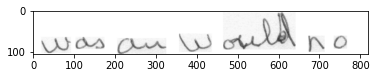

In [95]:
# TEST 1
plt.imshow(make_img(['f07-000-01-04','f07-000-02-06','f07-000-02-01','f07-000-04-05'], word_space=(32,2)))
generate_text(['f07-000-01-04','f07-000-02-06','f07-000-02-01','f07-000-04-05'])

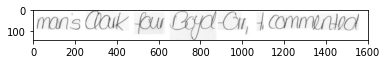

In [40]:
# TEST 2
plt.imshow(make_img(['a02-062-00-02', 'a02-062-02-00', 'a02-062-00-07', 'a02-062-06-01', 'a02-062-02-01'], 
                   (10,3)))
#plt.imshow(make_img(['g06-011o-00-08'], 
 #                   (0.91125,3.830961974)))


In [27]:
restricted_writers = ['550', '075', '304', '301', '120', '113', '461', '141', '494', '178', '561', '015', '272',
                     '165', '330', '376', '249', '165', '156', '586', '203', '668', '629', '159', '629']

In [26]:
# DESTRUCTIVE GENERATE

STARTID = 1100
MAX_NUMBER = 250
with open(f'{DEST_DIR}/images.csv','w') as debug_fp:
    with open(f'{DEST_DIR}/class_lookup.csv','w') as fp:
        fp.write('filename,class,text\n')
        max_number = MAX_NUMBER
        for wid, fids in writers_to_file_id.items():
           # print ('wid')
            if restricted_writers is not None and wid not in restricted_writers:
                continue
            for fid in fids:
                c = STARTID
                words = [k for k in all_images_idx if match_fid(k, fid)]
                #all_words_for_writer = get_words(fids)
                #print(len(fids))
                for sentence in generate_sentences(words,max_number=max(12,int(max_number/len(fids)))):
                    img_filename = f'{fid}-{wid}-{c}.png'
                    pathname = os.path.join(DEST_DIR,img_filename)
                    if os.path.exists(pathname):
                        raise ValueError(pathname)
                    w_nu = float(word_spacing[fid][0])
                    w_sd = float(word_spacing[fid][1])
                    for i in range(5):
                            try:
                                newimg = make_img(sentence,word_space=(w_nu, w_sd), factor = 1)
                                cv2.imwrite(pathname, newimg)
                                debug_fp.write(f'{img_filename},{",".join(sentence)}\n')
                                fp.write(f'{img_filename},{wid},|{generate_text(sentence)}|\n')
                                c+=1
                                if i>0:
                                    print('recovered')
                                break
                            except Exception as ex:
                                print(ex)
                                print(sentence)
                                print(w_nu, w_sd)
                                print(generate_text(sentence))



zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-01', 'a06-057-00-12', 'a06-057-05-01']
0.596666667 0.447690369
I effect be is
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-01', 'a06-057-00-12', 'a06-057-05-01']
0.596666667 0.447690369
I effect be is
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-01', 'a06-057-00-12', 'a06-057-05-01']
0.596666667 0.447690369
I effect be is
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-01', 'a06-057-00-12', 'a06-057-05-01']
0.596666667 0.447690369
I effect be is
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-01', 'a06-057-00-12', 'a06-057-05-01']
0.596666667 0.447690369
I effect be is
zero-size array to reduction operation maximum which has no identity
['a06-057-03-00', 'a06-057-00-10', 'a06-057-01

zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-08', 'a06-057-04-05', 'a06-057-05-04', 'a06-057-03-02']
0.596666667 0.447690369
I now supporter disaster Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-08', 'a06-057-04-05', 'a06-057-05-04', 'a06-057-03-02']
0.596666667 0.447690369
I now supporter disaster Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-08', 'a06-057-04-05', 'a06-057-05-04', 'a06-057-03-02']
0.596666667 0.447690369
I now supporter disaster Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-08', 'a06-057-04-05', 'a06-057-05-04', 'a06-057-03-02']
0.596666667 0.447690369
I now supporter disaster Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-00-10', 'a06-057-04-08', 'a06-057-04-05', 'a06-057-05-04', 'a06-057-03-02']
0.596

zero-size array to reduction operation maximum which has no identity
['a06-057-00-13', 'a06-057-00-10', 'a06-057-03-01', 'a06-057-02-07', 'a06-057-01-10']
0.596666667 0.447690369
told I the attack had
zero-size array to reduction operation maximum which has no identity
['a06-057-00-13', 'a06-057-00-10', 'a06-057-03-01', 'a06-057-02-07', 'a06-057-01-10']
0.596666667 0.447690369
told I the attack had
zero-size array to reduction operation maximum which has no identity
['a06-057-01-00', 'a06-057-00-07', 'a06-057-04-05', 'a06-057-00-10', 'a06-057-02-00']
0.596666667 0.447690369
to more supporter I from
zero-size array to reduction operation maximum which has no identity
['a06-057-01-00', 'a06-057-00-07', 'a06-057-04-05', 'a06-057-00-10', 'a06-057-02-00']
0.596666667 0.447690369
to more supporter I from
zero-size array to reduction operation maximum which has no identity
['a06-057-01-00', 'a06-057-00-07', 'a06-057-04-05', 'a06-057-00-10', 'a06-057-02-00']
0.596666667 0.447690369
to more sup

zero-size array to reduction operation maximum which has no identity
['a06-057-02-06', 'a06-057-04-07', 'a06-057-05-00', 'a06-057-00-12', 'a06-057-00-02', 'a06-057-05-02']
0.596666667 0.447690369
Fell's he Minister be to a
zero-size array to reduction operation maximum which has no identity
['a06-057-02-06', 'a06-057-04-07', 'a06-057-05-00', 'a06-057-00-12', 'a06-057-00-02', 'a06-057-05-02']
0.596666667 0.447690369
Fell's he Minister be to a
zero-size array to reduction operation maximum which has no identity
['a06-057-02-06', 'a06-057-04-07', 'a06-057-05-00', 'a06-057-00-12', 'a06-057-00-02', 'a06-057-05-02']
0.596666667 0.447690369
Fell's he Minister be to a
zero-size array to reduction operation maximum which has no identity
['a06-057-02-06', 'a06-057-04-07', 'a06-057-05-00', 'a06-057-00-12', 'a06-057-00-02', 'a06-057-05-02']
0.596666667 0.447690369
Fell's he Minister be to a
zero-size array to reduction operation maximum which has no identity
['a06-057-02-06', 'a06-057-04-07', 'a06

zero-size array to reduction operation maximum which has no identity
['a06-057-03-03', 'a06-057-04-08', 'a06-057-05-02', 'a06-057-02-00', 'a06-057-04-02', 'a06-057-02-08']
0.596666667 0.447690369
Minister now a from on was
zero-size array to reduction operation maximum which has no identity
['a06-057-03-03', 'a06-057-04-08', 'a06-057-05-02', 'a06-057-02-00', 'a06-057-04-02', 'a06-057-02-08']
0.596666667 0.447690369
Minister now a from on was
zero-size array to reduction operation maximum which has no identity
['a06-057-03-03', 'a06-057-04-08', 'a06-057-05-02', 'a06-057-02-00', 'a06-057-04-02', 'a06-057-02-08']
0.596666667 0.447690369
Minister now a from on was
zero-size array to reduction operation maximum which has no identity
['a06-057-03-03', 'a06-057-04-08', 'a06-057-05-02', 'a06-057-02-00', 'a06-057-04-02', 'a06-057-02-08']
0.596666667 0.447690369
Minister now a from on was
zero-size array to reduction operation maximum which has no identity
['a06-057-00-02', 'a06-057-05-02', 'a06

zero-size array to reduction operation maximum which has no identity
['a06-057-02-07', 'a06-057-05-02', 'a06-057-03-04', 'a06-057-00-12', 'a06-057-05-08', 'a06-057-04-11']
0.596666667 0.447690369
attack a of be said Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-02-07', 'a06-057-05-02', 'a06-057-03-04', 'a06-057-00-12', 'a06-057-05-08', 'a06-057-04-11']
0.596666667 0.447690369
attack a of be said Prime
zero-size array to reduction operation maximum which has no identity
['a06-057-00-01', 'a06-057-02-07', 'a06-057-03-07', 'a06-057-02-08', 'a06-057-00-10', 'a06-057-04-00']
0.596666667 0.447690369
seemed attack double was I the
zero-size array to reduction operation maximum which has no identity
['a06-057-00-01', 'a06-057-02-07', 'a06-057-03-07', 'a06-057-02-08', 'a06-057-00-10', 'a06-057-04-00']
0.596666667 0.447690369
seemed attack double was I the
zero-size array to reduction operation maximum which has no identity
['a06-057-00-01', 'a06-057-02-07'

zero-size array to reduction operation maximum which has no identity
['a06-057-04-04', 'a06-057-00-06', 'a06-057-01-06', 'a06-057-04-03', 'a06-057-04-08', 'a06-057-05-02']
0.596666667 0.447690369
former even Minister one now a
zero-size array to reduction operation maximum which has no identity
['a06-057-04-04', 'a06-057-00-06', 'a06-057-01-06', 'a06-057-04-03', 'a06-057-04-08', 'a06-057-05-02']
0.596666667 0.447690369
former even Minister one now a
zero-size array to reduction operation maximum which has no identity
['a06-057-04-04', 'a06-057-00-06', 'a06-057-01-06', 'a06-057-04-03', 'a06-057-04-08', 'a06-057-05-02']
0.596666667 0.447690369
former even Minister one now a
zero-size array to reduction operation maximum which has no identity
['a06-057-04-04', 'a06-057-00-06', 'a06-057-01-06', 'a06-057-04-03', 'a06-057-04-08', 'a06-057-05-02']
0.596666667 0.447690369
former even Minister one now a
zero-size array to reduction operation maximum which has no identity
['a06-057-04-04', 'a06-

zero-size array to reduction operation maximum which has no identity
['c04-017-00-04', 'c04-017-05-07', 'c04-017-01-07', 'c04-017-04-05', 'c04-017-05-02', 'c04-017-00-07']
1.28875 0.858661507
a first might by-passed has a
zero-size array to reduction operation maximum which has no identity
['c04-017-00-04', 'c04-017-05-07', 'c04-017-01-07', 'c04-017-04-05', 'c04-017-05-02', 'c04-017-00-07']
1.28875 0.858661507
a first might by-passed has a
zero-size array to reduction operation maximum which has no identity
['c04-017-00-04', 'c04-017-05-07', 'c04-017-01-07', 'c04-017-04-05', 'c04-017-05-02', 'c04-017-00-07']
1.28875 0.858661507
a first might by-passed has a
zero-size array to reduction operation maximum which has no identity
['c04-017-00-04', 'c04-017-05-07', 'c04-017-01-07', 'c04-017-04-05', 'c04-017-05-02', 'c04-017-00-07']
1.28875 0.858661507
a first might by-passed has a
zero-size array to reduction operation maximum which has no identity
['c04-017-00-04', 'c04-017-05-07', 'c04-017

zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-01-02', 'd06-003-03-02', 'd06-003-03-04']
1.177647059 0.664535341
by at a they
zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-01-02', 'd06-003-03-02', 'd06-003-03-04']
1.177647059 0.664535341
by at a they
zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-01-02', 'd06-003-03-02', 'd06-003-03-04']
1.177647059 0.664535341
by at a they
zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-01-02', 'd06-003-03-02', 'd06-003-03-04']
1.177647059 0.664535341
by at a they
zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-01-02', 'd06-003-03-02', 'd06-003-03-04']
1.177647059 0.664535341
by at a they
zero-size array to reduction operation maximum which has no identity
['d06-003-01-00', 'd06-003-02-03', 'd06-003-02-09', 'd06

zero-size array to reduction operation maximum which has no identity
['d06-076-05-00', 'd06-076-04-02', 'd06-076-00-06', 'd06-076-02-04', 'd06-076-04-04']
1.177647059 0.664535341
upstairs we rules a something
zero-size array to reduction operation maximum which has no identity
['d06-076-05-00', 'd06-076-04-02', 'd06-076-00-06', 'd06-076-02-04', 'd06-076-04-04']
1.177647059 0.664535341
upstairs we rules a something
zero-size array to reduction operation maximum which has no identity
['d06-076-05-00', 'd06-076-04-02', 'd06-076-00-06', 'd06-076-02-04', 'd06-076-04-04']
1.177647059 0.664535341
upstairs we rules a something
zero-size array to reduction operation maximum which has no identity
['d06-076-05-00', 'd06-076-04-02', 'd06-076-00-06', 'd06-076-02-04', 'd06-076-04-04']
1.177647059 0.664535341
upstairs we rules a something
zero-size array to reduction operation maximum which has no identity
['d06-076-03-07', 'd06-076-00-10', 'd06-076-02-04', 'd06-076-03-06', 'd06-076-05-04']
1.1776470

zero-size array to reduction operation maximum which has no identity
['g01-083-07-07', 'g01-083-04-06', 'g01-083-10-06', 'g01-083-05-10']
0.551176471 0.21292259
second assessment but manifest
zero-size array to reduction operation maximum which has no identity
['g01-083-07-07', 'g01-083-04-06', 'g01-083-10-06', 'g01-083-05-10']
0.551176471 0.21292259
second assessment but manifest
zero-size array to reduction operation maximum which has no identity
['g01-083-07-07', 'g01-083-04-06', 'g01-083-10-06', 'g01-083-05-10']
0.551176471 0.21292259
second assessment but manifest
zero-size array to reduction operation maximum which has no identity
['g01-083-07-07', 'g01-083-04-06', 'g01-083-10-06', 'g01-083-05-10']
0.551176471 0.21292259
second assessment but manifest
zero-size array to reduction operation maximum which has no identity
['g01-083-07-07', 'g01-083-04-06', 'g01-083-10-06', 'g01-083-05-10']
0.551176471 0.21292259
second assessment but manifest
zero-size array to reduction operation m

zero-size array to reduction operation maximum which has no identity
['g01-083-05-04', 'g01-083-08-06', 'g01-083-07-02', 'g01-083-09-08', 'g01-083-10-01']
0.551176471 0.21292259
of and the rate to
zero-size array to reduction operation maximum which has no identity
['g01-083-05-04', 'g01-083-08-06', 'g01-083-07-02', 'g01-083-09-08', 'g01-083-10-01']
0.551176471 0.21292259
of and the rate to
zero-size array to reduction operation maximum which has no identity
['g01-083-05-04', 'g01-083-08-06', 'g01-083-07-02', 'g01-083-09-08', 'g01-083-10-01']
0.551176471 0.21292259
of and the rate to
zero-size array to reduction operation maximum which has no identity
['g01-083-05-04', 'g01-083-08-06', 'g01-083-07-02', 'g01-083-09-08', 'g01-083-10-01']
0.551176471 0.21292259
of and the rate to
zero-size array to reduction operation maximum which has no identity
['g01-083-03-05', 'g01-083-02-10', 'g01-083-05-04', 'g01-083-10-01', 'g01-083-06-05']
0.551176471 0.21292259
the find of to been
zero-size arra

zero-size array to reduction operation maximum which has no identity
['g01-083-03-06', 'g01-083-10-00', 'g01-083-03-03', 'g01-083-04-08', 'g01-083-10-09', 'g01-083-06-06']
0.551176471 0.21292259
clergy had sum which an to
zero-size array to reduction operation maximum which has no identity
['g01-083-08-07', 'g01-083-07-01', 'g01-083-10-12', 'g01-083-00-01', 'g01-083-03-05', 'g01-083-10-06']
0.551176471 0.21292259
the by re- sum the but
zero-size array to reduction operation maximum which has no identity
['g01-083-08-07', 'g01-083-07-01', 'g01-083-10-12', 'g01-083-00-01', 'g01-083-03-05', 'g01-083-10-06']
0.551176471 0.21292259
the by re- sum the but
zero-size array to reduction operation maximum which has no identity
['g01-083-08-07', 'g01-083-07-01', 'g01-083-10-12', 'g01-083-00-01', 'g01-083-03-05', 'g01-083-10-06']
0.551176471 0.21292259
the by re- sum the but
zero-size array to reduction operation maximum which has no identity
['g01-083-08-07', 'g01-083-07-01', 'g01-083-10-12', 'g0

zero-size array to reduction operation maximum which has no identity
['g01-083-00-04', 'g01-083-00-08', 'g01-083-06-02', 'g01-083-10-04', 'g01-083-10-00', 'g01-083-04-00']
0.551176471 0.21292259
was staggering this groats had the
zero-size array to reduction operation maximum which has no identity
['g01-083-00-04', 'g01-083-00-08', 'g01-083-06-02', 'g01-083-10-04', 'g01-083-10-00', 'g01-083-04-00']
0.551176471 0.21292259
was staggering this groats had the
zero-size array to reduction operation maximum which has no identity
['g01-083-00-04', 'g01-083-00-08', 'g01-083-06-02', 'g01-083-10-04', 'g01-083-10-00', 'g01-083-04-00']
0.551176471 0.21292259
was staggering this groats had the
zero-size array to reduction operation maximum which has no identity
['g01-083-00-04', 'g01-083-00-08', 'g01-083-06-02', 'g01-083-10-04', 'g01-083-10-00', 'g01-083-04-00']
0.551176471 0.21292259
was staggering this groats had the
zero-size array to reduction operation maximum which has no identity
['g01-083-0

zero-size array to reduction operation maximum which has no identity
['g04-104-00-07', 'g04-104-07-03', 'g04-104-06-06', 'g04-104-06-07', 'g04-104-02-05', 'g04-104-02-04']
0.850666667 0.350378449
was who friendly contact I that
zero-size array to reduction operation maximum which has no identity
['g04-104-00-07', 'g04-104-07-03', 'g04-104-06-06', 'g04-104-06-07', 'g04-104-02-05', 'g04-104-02-04']
0.850666667 0.350378449
was who friendly contact I that
zero-size array to reduction operation maximum which has no identity
['g04-104-00-07', 'g04-104-07-03', 'g04-104-06-06', 'g04-104-06-07', 'g04-104-02-05', 'g04-104-02-04']
0.850666667 0.350378449
was who friendly contact I that
zero-size array to reduction operation maximum which has no identity
['g04-104-00-07', 'g04-104-07-03', 'g04-104-06-06', 'g04-104-06-07', 'g04-104-02-05', 'g04-104-02-04']
0.850666667 0.350378449
was who friendly contact I that
zero-size array to reduction operation maximum which has no identity
['g04-104-00-07', '

zero-size array to reduction operation maximum which has no identity
['h04-028-06-02', 'h04-028-09-05', 'h04-028-07-06', 'h04-028-09-08', 'h04-028-06-01']
1.182727273 0.365734628
steepest and per than being
zero-size array to reduction operation maximum which has no identity
['h04-028-06-02', 'h04-028-09-05', 'h04-028-07-06', 'h04-028-09-08', 'h04-028-06-01']
1.182727273 0.365734628
steepest and per than being
zero-size array to reduction operation maximum which has no identity
['h04-028-06-02', 'h04-028-09-05', 'h04-028-07-06', 'h04-028-09-08', 'h04-028-06-01']
1.182727273 0.365734628
steepest and per than being
zero-size array to reduction operation maximum which has no identity
['h04-028-06-02', 'h04-028-09-05', 'h04-028-07-06', 'h04-028-09-08', 'h04-028-06-01']
1.182727273 0.365734628
steepest and per than being
zero-size array to reduction operation maximum which has no identity
['h04-028-06-02', 'h04-028-09-05', 'h04-028-07-06', 'h04-028-09-08', 'h04-028-06-01']
1.182727273 0.365

zero-size array to reduction operation maximum which has no identity
['h04-028-05-06', 'h04-028-09-02', 'h04-028-07-06', 'h04-028-02-01', 'h04-028-01-06']
1.182727273 0.365734628
price to per very flour
zero-size array to reduction operation maximum which has no identity
['h04-028-05-06', 'h04-028-09-02', 'h04-028-07-06', 'h04-028-02-01', 'h04-028-01-06']
1.182727273 0.365734628
price to per very flour
zero-size array to reduction operation maximum which has no identity
['h04-028-05-06', 'h04-028-09-02', 'h04-028-07-06', 'h04-028-02-01', 'h04-028-01-06']
1.182727273 0.365734628
price to per very flour
zero-size array to reduction operation maximum which has no identity
['h04-028-05-06', 'h04-028-09-02', 'h04-028-07-06', 'h04-028-02-01', 'h04-028-01-06']
1.182727273 0.365734628
price to per very flour
zero-size array to reduction operation maximum which has no identity
['h04-028-05-06', 'h04-028-09-02', 'h04-028-07-06', 'h04-028-02-01', 'h04-028-01-06']
1.182727273 0.365734628
price to 

zero-size array to reduction operation maximum which has no identity
['h04-028-07-06', 'h04-028-05-05', 'h04-028-06-02', 'h04-028-01-05', 'h04-028-09-08', 'h04-028-00-00']
1.182727273 0.365734628
per the steepest and than The
zero-size array to reduction operation maximum which has no identity
['h04-028-07-06', 'h04-028-05-05', 'h04-028-06-02', 'h04-028-01-05', 'h04-028-09-08', 'h04-028-00-00']
1.182727273 0.365734628
per the steepest and than The
zero-size array to reduction operation maximum which has no identity
['h04-028-07-06', 'h04-028-05-05', 'h04-028-06-02', 'h04-028-01-05', 'h04-028-09-08', 'h04-028-00-00']
1.182727273 0.365734628
per the steepest and than The
zero-size array to reduction operation maximum which has no identity
['h04-028-07-06', 'h04-028-05-05', 'h04-028-06-02', 'h04-028-01-05', 'h04-028-09-08', 'h04-028-00-00']
1.182727273 0.365734628
per the steepest and than The
zero-size array to reduction operation maximum which has no identity
['h04-028-07-06', 'h04-028-

zero-size array to reduction operation maximum which has no identity
['h04-028-07-04', 'h04-028-08-03', 'h04-028-03-04', 'h04-028-03-02', 'h04-028-07-06', 'h04-028-01-06']
1.182727273 0.365734628
to fish paid childless per flour
zero-size array to reduction operation maximum which has no identity
['h04-028-07-04', 'h04-028-08-03', 'h04-028-03-04', 'h04-028-03-02', 'h04-028-07-06', 'h04-028-01-06']
1.182727273 0.365734628
to fish paid childless per flour
zero-size array to reduction operation maximum which has no identity
['h04-028-07-04', 'h04-028-08-03', 'h04-028-03-04', 'h04-028-03-02', 'h04-028-07-06', 'h04-028-01-06']
1.182727273 0.365734628
to fish paid childless per flour
zero-size array to reduction operation maximum which has no identity
['h04-028-07-04', 'h04-028-08-03', 'h04-028-03-04', 'h04-028-03-02', 'h04-028-07-06', 'h04-028-01-06']
1.182727273 0.365734628
to fish paid childless per flour
zero-size array to reduction operation maximum which has no identity
['h04-028-07-04

zero-size array to reduction operation maximum which has no identity
['h04-028-05-03', 'h04-028-07-06', 'h04-028-03-04', 'h04-028-09-06', 'h04-028-05-00', 'h04-028-05-05']
1.182727273 0.365734628
lowest per paid beverages large the
zero-size array to reduction operation maximum which has no identity
['n04-000-00-00', 'n04-000-02-04', 'n04-000-03-05', 'n04-000-02-06']
1.101818182 0.417698193
Bertram's I identically better
zero-size array to reduction operation maximum which has no identity
['n04-000-00-00', 'n04-000-02-04', 'n04-000-03-05', 'n04-000-02-06']
1.101818182 0.417698193
Bertram's I identically better
zero-size array to reduction operation maximum which has no identity
['n04-000-00-00', 'n04-000-02-04', 'n04-000-03-05', 'n04-000-02-06']
1.101818182 0.417698193
Bertram's I identically better
zero-size array to reduction operation maximum which has no identity
['n04-000-00-00', 'n04-000-02-04', 'n04-000-03-05', 'n04-000-02-06']
1.101818182 0.417698193
Bertram's I identically bet

zero-size array to reduction operation maximum which has no identity
['n02-028-06-02', 'n02-028-04-09', 'n02-028-00-01', 'n02-028-02-04', 'n02-028-02-09']
1.093125 0.715541753
next he and But and
zero-size array to reduction operation maximum which has no identity
['n02-028-06-02', 'n02-028-04-09', 'n02-028-00-01', 'n02-028-02-04', 'n02-028-02-09']
1.093125 0.715541753
next he and But and
zero-size array to reduction operation maximum which has no identity
['n02-028-06-02', 'n02-028-04-09', 'n02-028-00-01', 'n02-028-02-04', 'n02-028-02-09']
1.093125 0.715541753
next he and But and
zero-size array to reduction operation maximum which has no identity
['n02-028-06-02', 'n02-028-04-09', 'n02-028-00-01', 'n02-028-02-04', 'n02-028-02-09']
1.093125 0.715541753
next he and But and
zero-size array to reduction operation maximum which has no identity
['n02-028-06-02', 'n02-028-04-09', 'n02-028-00-01', 'n02-028-02-04', 'n02-028-02-09']
1.093125 0.715541753
next he and But and
zero-size array to r

zero-size array to reduction operation maximum which has no identity
['n02-049-03-04', 'n02-049-00-07', 'n02-049-01-06', 'n02-049-04-02']
1.093125 0.715541753
was riles I I
zero-size array to reduction operation maximum which has no identity
['n02-049-03-04', 'n02-049-00-07', 'n02-049-01-06', 'n02-049-04-02']
1.093125 0.715541753
was riles I I
zero-size array to reduction operation maximum which has no identity
['n02-049-03-04', 'n02-049-00-07', 'n02-049-01-06', 'n02-049-04-02']
1.093125 0.715541753
was riles I I
zero-size array to reduction operation maximum which has no identity
['n02-049-03-04', 'n02-049-00-07', 'n02-049-01-06', 'n02-049-04-02']
1.093125 0.715541753
was riles I I
zero-size array to reduction operation maximum which has no identity
['n02-049-03-04', 'n02-049-00-07', 'n02-049-01-06', 'n02-049-04-02']
1.093125 0.715541753
was riles I I
zero-size array to reduction operation maximum which has no identity
['n02-049-03-02', 'n02-049-02-01', 'n02-049-04-02', 'n02-049-03-05

zero-size array to reduction operation maximum which has no identity
['n02-049-03-00', 'n02-049-04-02', 'n02-049-02-10', 'n02-049-03-03', 'n02-049-02-01']
1.093125 0.715541753
look I You it Balicou
zero-size array to reduction operation maximum which has no identity
['n02-049-03-00', 'n02-049-04-02', 'n02-049-02-10', 'n02-049-03-03', 'n02-049-02-01']
1.093125 0.715541753
look I You it Balicou
zero-size array to reduction operation maximum which has no identity
['n02-049-04-03', 'n02-049-04-00', 'n02-049-04-02', 'n02-049-01-05', 'n02-049-02-07', 'n02-049-04-08']
1.093125 0.715541753
didn't as I How faintest letting
zero-size array to reduction operation maximum which has no identity
['n02-049-04-03', 'n02-049-04-00', 'n02-049-04-02', 'n02-049-01-05', 'n02-049-02-07', 'n02-049-04-08']
1.093125 0.715541753
didn't as I How faintest letting
zero-size array to reduction operation maximum which has no identity
['n02-049-04-03', 'n02-049-04-00', 'n02-049-04-02', 'n02-049-01-05', 'n02-049-02-07

zero-size array to reduction operation maximum which has no identity
['n02-049-02-00', 'n02-049-04-00', 'n02-049-04-02', 'n02-049-05-01', 'n02-049-01-10', 'n02-049-03-02']
1.093125 0.715541753
at as I his marooned though
zero-size array to reduction operation maximum which has no identity
['n02-049-02-00', 'n02-049-04-00', 'n02-049-04-02', 'n02-049-05-01', 'n02-049-01-10', 'n02-049-03-02']
1.093125 0.715541753
at as I his marooned though
zero-size array to reduction operation maximum which has no identity
['n02-049-03-05', 'n02-049-04-03', 'n02-049-00-06', 'n02-049-00-12', 'n02-049-01-06', 'n02-049-02-04']
1.093125 0.715541753
only didn't that was I you
zero-size array to reduction operation maximum which has no identity
['n02-049-03-05', 'n02-049-04-03', 'n02-049-00-06', 'n02-049-00-12', 'n02-049-01-06', 'n02-049-02-04']
1.093125 0.715541753
only didn't that was I you
zero-size array to reduction operation maximum which has no identity
['n02-049-03-05', 'n02-049-04-03', 'n02-049-00-06

zero-size array to reduction operation maximum which has no identity
['n02-049-00-11', 'n02-049-02-08', 'n02-049-01-08', 'n02-049-04-03', 'n02-049-05-01', 'n02-049-01-06']
1.093125 0.715541753
Beryl degree to didn't his I
zero-size array to reduction operation maximum which has no identity
['n02-049-00-11', 'n02-049-02-08', 'n02-049-01-08', 'n02-049-04-03', 'n02-049-05-01', 'n02-049-01-06']
1.093125 0.715541753
Beryl degree to didn't his I
zero-size array to reduction operation maximum which has no identity
['n02-049-00-11', 'n02-049-02-08', 'n02-049-01-08', 'n02-049-04-03', 'n02-049-05-01', 'n02-049-01-06']
1.093125 0.715541753
Beryl degree to didn't his I
zero-size array to reduction operation maximum which has no identity
['n02-049-00-11', 'n02-049-02-08', 'n02-049-01-08', 'n02-049-04-03', 'n02-049-05-01', 'n02-049-01-06']
1.093125 0.715541753
Beryl degree to didn't his I
zero-size array to reduction operation maximum which has no identity
['n02-049-00-11', 'n02-049-02-08', 'n02-049

zero-size array to reduction operation maximum which has no identity
['p03-163-07-01', 'p03-163-02-07', 'p03-163-05-04', 'p03-163-00-02', 'p03-163-06-02']
1.3475 0.714041565
minute know a I an
zero-size array to reduction operation maximum which has no identity
['p03-163-07-01', 'p03-163-02-07', 'p03-163-05-04', 'p03-163-00-02', 'p03-163-06-02']
1.3475 0.714041565
minute know a I an
zero-size array to reduction operation maximum which has no identity
['p03-163-07-01', 'p03-163-02-07', 'p03-163-05-04', 'p03-163-00-02', 'p03-163-06-02']
1.3475 0.714041565
minute know a I an
zero-size array to reduction operation maximum which has no identity
['p03-163-07-01', 'p03-163-02-07', 'p03-163-05-04', 'p03-163-00-02', 'p03-163-06-02']
1.3475 0.714041565
minute know a I an
zero-size array to reduction operation maximum which has no identity
['p03-163-07-01', 'p03-163-02-07', 'p03-163-05-04', 'p03-163-00-02', 'p03-163-06-02']
1.3475 0.714041565
minute know a I an
zero-size array to reduction operat

zero-size array to reduction operation maximum which has no identity
['p03-163-00-02', 'p03-163-04-03', 'p03-163-05-04', 'p03-163-00-13', 'p03-163-02-04']
1.3475 0.714041565
I like a my joking
zero-size array to reduction operation maximum which has no identity
['p03-163-00-02', 'p03-163-04-03', 'p03-163-05-04', 'p03-163-00-13', 'p03-163-02-04']
1.3475 0.714041565
I like a my joking
zero-size array to reduction operation maximum which has no identity
['p03-163-00-02', 'p03-163-04-03', 'p03-163-05-04', 'p03-163-00-13', 'p03-163-02-04']
1.3475 0.714041565
I like a my joking
zero-size array to reduction operation maximum which has no identity
['p03-163-00-02', 'p03-163-04-03', 'p03-163-05-04', 'p03-163-00-13', 'p03-163-02-04']
1.3475 0.714041565
I like a my joking
zero-size array to reduction operation maximum which has no identity
['p03-163-00-02', 'p03-163-04-03', 'p03-163-05-04', 'p03-163-00-13', 'p03-163-02-04']
1.3475 0.714041565
I like a my joking
zero-size array to reduction operat

zero-size array to reduction operation maximum which has no identity
['p03-163-00-04', 'p03-163-02-06', 'p03-163-07-04', 'p03-163-07-03', 'p03-163-00-02', 'p03-163-03-08']
1.3475 0.714041565
it You she and I joke
zero-size array to reduction operation maximum which has no identity
['p03-163-00-04', 'p03-163-02-06', 'p03-163-07-04', 'p03-163-07-03', 'p03-163-00-02', 'p03-163-03-08']
1.3475 0.714041565
it You she and I joke
zero-size array to reduction operation maximum which has no identity
['p03-163-00-04', 'p03-163-02-06', 'p03-163-07-04', 'p03-163-07-03', 'p03-163-00-02', 'p03-163-03-08']
1.3475 0.714041565
it You she and I joke
zero-size array to reduction operation maximum which has no identity
['p03-163-00-04', 'p03-163-02-06', 'p03-163-07-04', 'p03-163-07-03', 'p03-163-00-02', 'p03-163-03-08']
1.3475 0.714041565
it You she and I joke
zero-size array to reduction operation maximum which has no identity
['p03-163-00-04', 'p03-163-02-06', 'p03-163-07-04', 'p03-163-07-03', 'p03-163-0

zero-size array to reduction operation maximum which has no identity
['p03-163-07-00', 'p03-163-05-03', 'p03-163-00-02', 'p03-163-02-04', 'p03-163-05-01', 'p03-163-01-06']
1.3475 0.714041565
any such I joking Don't to
zero-size array to reduction operation maximum which has no identity
['p03-163-07-00', 'p03-163-05-03', 'p03-163-00-02', 'p03-163-02-04', 'p03-163-05-01', 'p03-163-01-06']
1.3475 0.714041565
any such I joking Don't to
zero-size array to reduction operation maximum which has no identity
['p03-163-07-00', 'p03-163-05-03', 'p03-163-00-02', 'p03-163-02-04', 'p03-163-05-01', 'p03-163-01-06']
1.3475 0.714041565
any such I joking Don't to
zero-size array to reduction operation maximum which has no identity
['p03-163-07-00', 'p03-163-05-03', 'p03-163-00-02', 'p03-163-02-04', 'p03-163-05-01', 'p03-163-01-06']
1.3475 0.714041565
any such I joking Don't to
zero-size array to reduction operation maximum which has no identity
['p03-163-07-00', 'p03-163-05-03', 'p03-163-00-02', 'p03-16

In [99]:
### REGENERATE (if needed)!

with open(f'{DEST_DIR}/images.csv','r') as debug_fp:
    lines = [line.strip().split(',') for line in debug_fp.readlines()]
    for line in lines:
        fn= line[0]
        pathname = os.path.join(DEST_DIR,fn)
        fid = '-'.join(fn.split('-')[0:2])
        img = cv2.imread(pathname)
        w_nu = float(word_spacing[fid][0])
        w_sd = float(word_spacing[fid][1])
        newimg = make_img(line[1:], 
                    (w_nu, w_sd), factor = 1)
        cv2.imwrite(pathname, newimg)